In [2]:
import pandas as pd
import datetime as dt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import numpy as np
from uszipcode import SearchEngine
import pickle
import seaborn as sns
%matplotlib inline

# load the Data

In [3]:
df = pd.read_csv("data/assessments.csv",low_memory=False)
pd.set_option('display.max_rows', 200)

# Transform Data

In [4]:
# prepare the data 
# the zipcode information contains a typo at row 142359
df1 = df.copy()
df1 = df1.dropna(how='all')
df1 = df1.dropna(subset=['SALEPRICE', 'SALEDATE','PROPERTYCITY','PROPERTYZIP'])
df1 = df1.reset_index(drop=True)
df1.at[142359,'PROPERTYZIP'] =  15017.
df1['year'] = df1['SALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y').year)
df1['month'] = df1['SALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y').month)
df1['PROPERTYZIP'] = df1['PROPERTYZIP'].astype('int')
df1['PROPERTYZIP'] = df1['PROPERTYZIP'].astype('str')

In [5]:
def get_location(df):
    engine = SearchEngine()
    zipcode_dict = {}
    for zipcode in df['PROPERTYZIP'].unique():
        try:
            zc = engine.by_zipcode(zipcode)
            zipcode_dict[zipcode] = [zc.lng, zc.lat]
        except:
            print(zipcode)
            zipcode_dict[zipcode] = [np.nan, np.nan]
    return zipcode_dict

In [6]:
def school_map(df):
    school_ranking = ['North Allegheny', 'Mt Lebanon','Fox Chapel Area','Upper St Clair','South Fayette Twp','Hampton Township','Quaker Valley',
                    'Montour','Pine-Richland','Moon Area','North Hills','Plum Boro','Bethel Park','Riverview','West Jefferson Hills',
                    'Keystone Oaks','Elizabeth Forward','Baldwin Whitehall','Gateway','West Allegheny','South Park','Avonworth','Shaler Area',
                    'Chartiers Valley','Northgate', 'Deer Lakes','Brentwood Boro','Pittsburgh', 'Woodland Hills', 'Steel Valley','Carlynton', 
                    'McKeesport Area','West Mifflin Area','Penn Hills Twp', 'Cornell','Highlands','East Allegheny', 'Clairton City',
                    'Allegheny Valley', 'Sto-Rox', 'South Allegheny','Wilkinsburg Boro']
    ranking = [x for x in range(1,len(school_ranking)+1)]
    ranking_dict = dict(zip(school_ranking, ranking))
    school_missing = [x for x in df.SCHOOLDESC.unique() if x not in school_ranking]
    missing_map = {}
    for zc in df.PROPERTYZIP.unique():
        schools = list(df[df['PROPERTYZIP']==zc]['SCHOOLDESC'].unique())
        for s in schools:
            if s in school_missing:
                if s not in missing_map:
                    missing_map[s] = schools
                    missing_map[s].remove(s)
                else:
                    missing_map[s] += schools
                    missing_map[s].remove(s)
    for key in missing_map:
        missing_map[key] = np.array(list(map(ranking_dict.get, missing_map[key]))).mean()
        school_ranking_dict = dict(zip(list(missing_map.keys())+list(ranking_dict.keys()),list(missing_map.values())+list(ranking_dict.values())))
    return dict(zip(list(missing_map.keys())+list(ranking_dict.keys()),list(missing_map.values())+list(ranking_dict.values())))


In [7]:
# map zip code to longitude and latitude
# map school district to ranking number
zipcode_dict = get_location(df1)
school_ranking_dict= school_map(df1)

In [8]:
class Features_Transformer(object):
    """Class that transform categorical features into numeric features and fill the missing data.
    
    Data cleaning process of trasform original features to numeric features.
    Dummy transform is at the end of the process.
    
    Attributes:
        zipcode_dict: hash map between zip code and longitude, latitude
        school_ranking_dict:  hash map between school district and ranking
    """
    
    def __init__(self, zipcode_dict, school_ranking_dict): 
        
        """Inits Features_Transformer"""
        
        self.zipcode_dict = zipcode_dict
        self.school_ranking_dict = school_ranking_dict 
        
        # ranking list to transform categorical features with ranking
        self.grade_ranking_list = ['XX+','XX','XX-','X+','X','X-','A+','A','A-','B+','B','B-',
                                   'C+','C','C-','D+','D','D-','E+','E','E-']
        self.CDU_ranking_list = ['EXCELLENT', 'VERY GOOD', 'GOOD','AVERAGE','FAIR', 'POOR',
                                 'VERY POOR','UNSOUND']
        
        self.feature_location = []
        self.feature_mean = []
        # 
        self.cat_features = ['TAXDESC','TAXSUBCODE_DESC','OWNERDESC','CLASSDESC','SALEDESC', 
                             'STYLEDESC','EXTFINISH_DESC','ROOFDESC','BASEMENTDESC',
                             'HEATINGCOOLINGDESC']
        self.missing_numeric_features = ['FIREPLACES', 'BSMTGARAGE', 'HALFBATHS', 'ROOF', 
                                         'FULLBATHS', 'BASEMENT', 'TOTALROOMS', 'CONDITION', 
                                         'BEDROOMS', 'EXTERIORFINISH', 'STORIES', 
                                         'FINISHEDLIVINGAREA', 'CARDNUMBER', 'YEARBLT' ]
        self.additional_feature = ['MUNICODE', 'SCHOOLCODE', 'OWNERCODE', 'USECODE', 'LOTAREA', 
                                   'COUNTYBUILDING', 'COUNTYLAND', 'COUNTYTOTAL', 'COUNTYEXEMPTBLDG', 
                                   'LOCALBUILDING', 'LOCALLAND', 'LOCALTOTAL', 'FAIRMARKETBUILDING', 
                                   'FAIRMARKETLAND', 'FAIRMARKETTOTAL']

        self.dummy_features = ['TAXDESC','TAXSUBCODE_DESC', 'OWNERDESC', 'CLASSDESC', 'SALEDESC', 
                               'STYLEDESC','EXTFINISH_DESC','ROOFDESC','BASEMENTDESC',
                               'HEATINGCOOLINGDESC']

    
    def fit(self, X, y=None):
        """fit the features"""
        
        df = pd.DataFrame()
        
        # combine the address
        df['PROPERTYHOUSENUM'] = X['PROPERTYHOUSENUM'].astype('str')
        df['PROPERTYADDRESS'] = X['PROPERTYADDRESS']
        df['PROPERTYCITY'] = X['PROPERTYCITY']
        df['PROPERTYSTATE'] = X['PROPERTYSTATE']
        df['PROPERTYZIP'] = X['PROPERTYZIP'].astype('int')
        df['PROPERTYZIP'] = df['PROPERTYZIP'].astype('str')
        df['address'] = df[['PROPERTYHOUSENUM','PROPERTYADDRESS','PROPERTYCITY','PROPERTYSTATE','PROPERTYZIP']].agg(' '.join, axis=1)
        
        # drop useless features after getting the address
        df = df.drop(columns=['PROPERTYHOUSENUM', 'PROPERTYADDRESS', 'PROPERTYCITY','PROPERTYSTATE'])
        
        # fill the missing date with the later one
        df['PREVSALEDATE'] = X['PREVSALEDATE'].fillna(X['SALEDATE'])
        df['PREVSALEDATE2'] = X['PREVSALEDATE2'].fillna(df['PREVSALEDATE'])
        
        # fill the missing dale price with the later one
        df['SALEPRICE'] = X['SALEPRICE']
        df['PREVSALEPRICE'] = X['PREVSALEPRICE'].fillna(X['SALEPRICE'])
        df['PREVSALEPRICE2'] = X['PREVSALEPRICE2'].fillna(df['PREVSALEPRICE'])
         
        # change date features to datetime object
        df['SALEDATE'] = X['SALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        df['PREVSALEDATE'] = df['PREVSALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        df['PREVSALEDATE2'] = df['PREVSALEDATE2'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        
        # adding timestamp from datetime object
        df['Timestamp0'] = df['SALEDATE'].apply(lambda x: x.timestamp())
        df['Timestamp1'] = df['PREVSALEDATE'].apply(lambda x: x.timestamp())
        df['Timestamp2'] = df['PREVSALEDATE2'].apply(lambda x: x.timestamp())
        
        # drop datetime object
        df = df.drop(columns=['SALEDATE', 'PREVSALEDATE','PREVSALEDATE2'])
        
        # map the school ranking hashmap to school disctrict
        df['SCHOOL_Ranking'] = X['SCHOOLDESC'].map(school_ranking_dict)
        
        # change binary categorical features to 0 and 1
        # missing value is 0
        df['HOMESTEADFLAG'] = X['HOMESTEADFLAG'].notnull().astype('int')
        df['FARMSTEADFLAG'] = X['FARMSTEADFLAG'].notnull().astype('int')
        df['CLEANGREEN'] = X['CLEANGREEN'].notnull().astype('int')
        df['ABATEMENTFLAG'] = X['ABATEMENTFLAG'].notnull().astype('int')
        
        # map the zip code to longitude, latitude 
        # get the locations to fill other features' missing values
        df['longitude'] = df['PROPERTYZIP'].apply(lambda x: zipcode_dict[x][0])
        df['latitude'] = df['PROPERTYZIP'].apply(lambda x: zipcode_dict[x][1])
        df['location']=list(zip(df['longitude'], df['latitude']))
        
        # map GRADE features with ranking
        # fill missing values with location information
        # if anything else is missing, fill it with the mean
        df['GRADE'] = X['GRADE'].map(dict(zip(self.grade_ranking_list, range(1,len(self.grade_ranking_list)+1))))
        self.grade_mean = df['GRADE'].mean()
        self.grade_location =df['location'].map(df[['location','GRADE']].dropna().groupby('location').mean().to_dict()['GRADE'])
        df['GRADE'] = df['GRADE'].fillna(self.grade_location)
        df['GRADE'] = df['GRADE'].fillna(self.grade_mean)
        
        # map CDU features with ranking
        # fill missing values with location information
        # if anything else is missing, fill it with the mean
        df['CDUDESC'] = X['CDUDESC'].map(dict(zip(self.CDU_ranking_list, range(1,len(self.CDU_ranking_list)+1))))
        self.CDU_mean = df['CDUDESC'].mean()
        self.CDU_location = df['location'].map(df[['location','CDUDESC']].dropna().groupby('location').mean().to_dict()['CDUDESC'])
        df['CDUDESC'] = df['CDUDESC'].fillna(self.CDU_location)
        df['CDUDESC'] = df['CDUDESC'].fillna(self.CDU_mean)
        
        # replace None values with NaN in cat_features,
        # prepare for dummy transform
        for feature in self.cat_features:
            df[feature] = X[feature].replace('None',np.nan)
        
        # replace special None values with NaN
        # prepare for dummy transform
        df['CLASSDESC'] = X['CLASSDESC'].replace('OTHER','CLASS_OTHER')
        df['SALEDESC'] = X['SALEDESC'].replace('OTHER','SALE_OTHER')
        df['STYLEDESC'] = X['STYLEDESC'].replace('OTHER','STYLE_OTHER')
        df['HEATINGCOOLINGDESC'] = X['HEATINGCOOLINGDESC'].replace('Other','HEATINGCOOLING_OTHER')
    
        # fill missing values in numeric features with location information
        for i, feature in enumerate(self.missing_numeric_features):
            df[feature] = X[feature]
            self.feature_location.append(df['location'].map(df[['location',feature]].dropna().groupby('location').mean().to_dict()[feature]))
            self.feature_mean.append(df[feature].mean())
            df[feature] = df[feature].fillna(self.feature_location[i])
            df[feature] = df[feature].fillna(self.feature_mean[i])
            if feature != 'FINISHEDLIVINGAREA':
                df[feature] = df[feature].astype('int')
        
        # drop useless features        
        df = df.drop(columns=['location','PROPERTYZIP','address'])
        
        # merge current features with additional_features
        df = pd.concat([df,X[self.additional_feature]],axis=1)
              
        # transform dummy_features using get_dummies
        df_dummy = pd.get_dummies(df[self.dummy_features])
        
        # drop original dummy_features and combine current features with dummy features
        df = df.drop(columns=self.dummy_features)
        df = pd.concat([df,df_dummy],axis=1)

    def transform(self, X, y=None):
        """transform the features"""
        
        df = pd.DataFrame()
        df['PROPERTYHOUSENUM'] = X['PROPERTYHOUSENUM'].astype('str')
        df['PROPERTYADDRESS'] = X['PROPERTYADDRESS']
        df['PROPERTYCITY'] = X['PROPERTYCITY']
        df['PROPERTYSTATE'] = X['PROPERTYSTATE']
        df['PROPERTYZIP'] = X['PROPERTYZIP'].astype('int')
        df['PROPERTYZIP'] = df['PROPERTYZIP'].astype('str')
        
        df['address'] = df[['PROPERTYHOUSENUM','PROPERTYADDRESS','PROPERTYCITY','PROPERTYSTATE','PROPERTYZIP']].agg(' '.join, axis=1)
        df = df.drop(columns=['PROPERTYHOUSENUM', 'PROPERTYADDRESS', 'PROPERTYCITY','PROPERTYSTATE'])
        
        df['PREVSALEDATE'] = X['PREVSALEDATE'].fillna(X['SALEDATE'])
        df['PREVSALEDATE2'] = X['PREVSALEDATE2'].fillna(df['PREVSALEDATE'])
        
        df['SALEPRICE'] = X['SALEPRICE']
        df['PREVSALEPRICE'] = X['PREVSALEPRICE'].fillna(X['SALEPRICE'])
        df['PREVSALEPRICE2'] = X['PREVSALEPRICE2'].fillna(df['PREVSALEPRICE'])
        
        df['SALEDATE'] = X['SALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        df['PREVSALEDATE'] = df['PREVSALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        df['PREVSALEDATE2'] = df['PREVSALEDATE2'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        
        #df['Timestamp0'] = df['SALEDATE'].values.astype(np.int64) // 10 ** 9
        #df['Timestamp1'] = df['PREVSALEDATE'].values.astype(np.int64) // 10 ** 9
        #df['Timestamp2'] = df['PREVSALEDATE2'].values.astype(np.int64) // 10 ** 9
        df['Timestamp0'] = df['SALEDATE'].apply(lambda x: x.timestamp())
        df['Timestamp1'] = df['PREVSALEDATE'].apply(lambda x: x.timestamp())
        df['Timestamp2'] = df['PREVSALEDATE2'].apply(lambda x: x.timestamp())
        
        df = df.drop(columns=['SALEDATE', 'PREVSALEDATE','PREVSALEDATE2'])
        
        df['SCHOOL_Ranking'] = X['SCHOOLDESC'].map(school_ranking_dict)
        
        df['HOMESTEADFLAG'] = X['HOMESTEADFLAG'].notnull().astype('int')
        df['FARMSTEADFLAG'] = X['FARMSTEADFLAG'].notnull().astype('int')
        df['CLEANGREEN'] = X['CLEANGREEN'].notnull().astype('int')
        df['ABATEMENTFLAG'] = X['ABATEMENTFLAG'].notnull().astype('int')
        
        df['longitude'] = df['PROPERTYZIP'].apply(lambda x: zipcode_dict[x][0])
        df['latitude'] = df['PROPERTYZIP'].apply(lambda x: zipcode_dict[x][1])
        df['location']=list(zip(df['longitude'], df['latitude']))
        
        df['GRADE'] = X['GRADE'].map(dict(zip(self.grade_ranking_list, range(1,len(self.grade_ranking_list)+1))))
        df['GRADE'] = df['GRADE'].fillna(self.grade_location)
        df['GRADE'] = df['GRADE'].fillna(self.grade_mean)
    
        df['CDUDESC'] = X['CDUDESC'].map(dict(zip(self.CDU_ranking_list, range(1,len(self.CDU_ranking_list)+1))))
        df['CDUDESC'] = df['CDUDESC'].fillna(self.CDU_location)
        df['CDUDESC'] = df['CDUDESC'].fillna(self.CDU_mean)
        
        for feature in self.cat_features:
            df[feature] = X[feature].replace('None',np.nan)
            
        df['CLASSDESC'] = X['CLASSDESC'].replace('OTHER','CLASS_OTHER')
        df['SALEDESC'] = X['SALEDESC'].replace('OTHER','SALE_OTHER')
        df['STYLEDESC'] = X['STYLEDESC'].replace('OTHER','STYLE_OTHER')
        df['HEATINGCOOLINGDESC'] = X['HEATINGCOOLINGDESC'].replace('Other','HEATINGCOOLING_OTHER')
        
        for i, feature in enumerate(self.missing_numeric_features):
            df[feature] = X[feature]
            df[feature] = df[feature].fillna(self.feature_location[i])
            df[feature] = df[feature].fillna(self.feature_mean[i])
            if feature != 'FINISHEDLIVINGAREA':
                df[feature] = df[feature].astype('int')
                
        df = df.drop(columns=['location','PROPERTYZIP','address'])
        
        df = pd.concat([df,X[self.additional_feature]],axis=1)
        
        df_dummy = pd.get_dummies(df[self.dummy_features])
        df = df.drop(columns=self.dummy_features)
        df = pd.concat([df,df_dummy],axis=1)
       
        return df
    
    def fit_transform(self, X, y=None):
        """fit and transform the features"""
        self.fit(X)
        return self.transform(X)

# Remove unreasonable small housing price

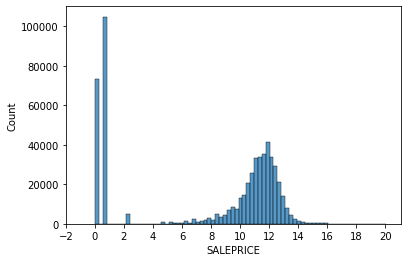

In [9]:
# plot the log(price+1) distribution to avoid 0 price
fig, ax = plt.subplots()
sns.histplot(np.log(df1.SALEPRICE+1), ax = ax)
# change the limits of X-axis
ax.set_xticks(list(range(-2,22,2)))
plt.show()


In [10]:
# remove large amount of 0 or near 0 housing price
df1 = df1[df1.SALEPRICE>10].reset_index(drop = True)
ftf = Features_Transformer(zipcode_dict, school_ranking_dict)
df2 = ftf.fit_transform(df1)

<AxesSubplot:xlabel='SALEPRICE', ylabel='Count'>

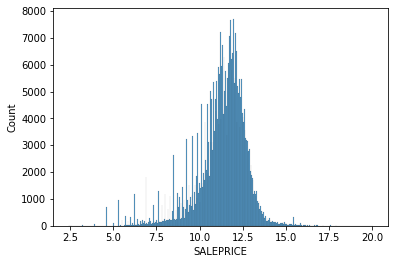

In [11]:
# plot the log(price) distribution
sns.histplot(np.log(df1.SALEPRICE))

In [12]:
# check input data set
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389868 entries, 0 to 389867
Columns: 154 entries, SALEPRICE to HEATINGCOOLINGDESC_Wall Furnace with AC
dtypes: float64(12), int32(17), int64(15), uint8(110)
memory usage: 146.5 MB


# Train the Model

In [13]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

In [14]:
# prepare training features X and target y

# Transform the raw data
# seperate features and target
# target is the SALEPRICE

features = list(df2.columns)
target = 'SALEPRICE'
features.remove(target)
for feature in ['PREVSALEPRICE','PREVSALEPRICE2','Timestamp1','Timestamp2']:
    features.remove(feature)
X = df2[features].copy()

# price change to log(price)
y = np.log(df2[target].copy())

In [15]:
# build a pipeline including normalization and XGB model
# fit the pipeline and predict the log(price)
steps = [('Rescale', StandardScaler()),
         ('tree', XGBRegressor(n_estimators=500, max_depth=11, eta=0.1,
                               subsample=1,colsample_bytree=1))]
pipe = Pipeline(steps)
xgb = pipe .fit(X, y)

y_pred = xgb.predict(X)

train MAE: 2.37e-01
train MSE: 1.56e-01
train R2: 0.930


(2.0, 20.0)

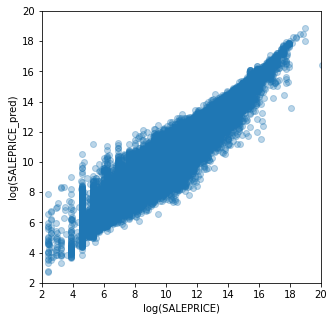

In [16]:
# check the metric of the model
# plot the predictions and the ground truth
print('train MAE: {0:.2e}'.format(mean_absolute_error(y, y_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y, y_pred)))
print('train R2: {0:.3f}'.format(r2_score(y, y_pred)))

plt.figure(figsize=(5,5))
plt.scatter(y, y_pred, alpha = 0.3)
plt.xlabel('log(SALEPRICE)')
plt.ylabel('log(SALEPRICE_pred)')
plt.xlim([2, 20])
plt.ylim([2, 20])

train MAE: 4.06e+04
train MSE: 8.44e+11


(0.0, 200000000.0)

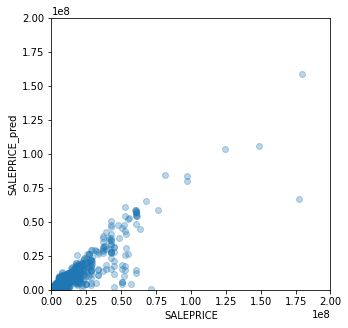

In [17]:
# calculate the MAE and MSE for the price transform back from log(price)
# plot the predicted price and the ground truth
print('train MAE: {0:.2e}'.format(mean_absolute_error(np.exp(y), np.exp(y_pred))))
print('train MSE: {0:.2e}'.format(mean_squared_error(np.exp(y), np.exp(y_pred))))
#print('train R2: {0:.3f}'.format(r2_score(np.exp(y), np.exp(y_pred))))

plt.figure(figsize=(5,5))
plt.scatter(np.exp(y), np.exp(y_pred), alpha = 0.3)
plt.xlabel('SALEPRICE')
plt.ylabel('SALEPRICE_pred')
plt.xlim([0, 2e8])
plt.ylim([0, 2e8])

In [18]:
# save the model and the input features for housing price prediction function: predict_price.py
pickle.dump(xgb, open( "data/xgb_reg.pkl", "wb"))

In [15]:
#constract a time dataframe
#adding information related to time and housing price
X['SALEDATE'] = df1.SALEDATE.copy().apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))

In [16]:
pickle.dump(X, open("data/X.pkl", "wb"))

The reason to run the predict_price.py seperately is:

We want to predict the housing price for all existed properties in the time period from the first date to the last date within the dataset.
There are around 55,000 days and around 390,000 properties and it takes time for this around calculation
We use a multiprocessing CPUs to accelerate the for-loop calculations in a seperate function called predict_price.py

# Home Value Index (HVI)

In [17]:
from dateutil import rrule

In [18]:
X['year'] = X['SALEDATE'].dt.year
X['month'] = X['SALEDATE'].dt.month
X['SALEPRICE'] = np.exp(y)
# get the the initial and final datetime
start, end = X['SALEDATE'].min(), X['SALEDATE'].max()
start, end

(Timestamp('1870-11-12 00:00:00'), Timestamp('2022-05-19 00:00:00'))

In [19]:
# The df_time contains the time information including datetime object, timestamp, year and month
df_time = pd.DataFrame(columns = ['SALEDATE'],data = [start.to_pydatetime() + dt.timedelta(days=i) for i in range((end.to_pydatetime()-start.to_pydatetime()).days+1) ])
df_time['Timestamp0'] = df_time['SALEDATE'].apply(lambda x: x.timestamp())
df_time['year'] = df_time.SALEDATE.dt.year
df_time['month'] = df_time.SALEDATE.dt.month
df_time

,SALEDATE,Timestamp0,year,month
0,1870-11-12,-3.128458e+09,1870,11
1,1870-11-13,-3.128371e+09,1870,11
2,1870-11-14,-3.128285e+09,1870,11
3,1870-11-15,-3.128198e+09,1870,11
4,1870-11-16,-3.128112e+09,1870,11
...,...,...,...,...
55336,2022-05-15,1.652573e+09,2022,5
55337,2022-05-16,1.652659e+09,2022,5
55338,2022-05-17,1.652746e+09,2022,5
55339,2022-05-18,1.652832e+09,2022,5


In [20]:
# load the price prediction list results from the predict_price.py
# it include the total price of the properties in each time point as in the df_time['SALEDATE'] columns
results_ = pickle.load(open('data/results_sum.pkl', "rb"))

In [21]:
#get start and end year-month
start_month_year = dt.datetime.strptime(str(start.year)+'-'+str(start.month), '%Y-%m')
end_month_year = dt.datetime.strptime(str(end.year)+'-'+str(end.month), '%Y-%m')

# combine the sum of all property prices with df_time
# This is the total price of all properties for each day 
df_price_sum =pd.DataFrame([df_time.SALEDATE.values, results_]).T
df_price_sum = df_price_sum.rename(columns={0: 'SALEDATE', 1: 'SALEPRICE_sum'})  
df_price_sum = df_price_sum.set_index('SALEDATE',drop=True)

# groupby the sum of the property prices by year and month and calculate the average
# SALEPRICE_sum is the average of total price of all properties in a month
df_month_sum = df_price_sum.groupby(by=[df_price_sum.index.year, df_price_sum.index.month]).mean()
df_month_sum.index = [dt for dt in rrule.rrule(rrule.MONTHLY, dtstart=start_month_year, until=end_month_year)]
df_month_sum

,SALEPRICE_sum
1870-11-01,1.427568e+07
1870-12-01,1.427568e+07
1871-01-01,1.461363e+07
1871-02-01,1.461363e+07
1871-03-01,1.461363e+07
...,...
2022-01-01,1.012354e+11
2022-02-01,1.012978e+11
2022-03-01,1.039223e+11
2022-04-01,1.040301e+11


In [22]:
#In the dataset, count the total number of properties in Allegheny County at certain year
#using 'YEAEBLT' feature
# start from year 1870 to year 2022 
# generate the hash map between year and total property numbers
n_house_dict = {}
for year in range(1870,2023):
    n_house_dict[year]=len(X[X['YEARBLT'] <= year])
df_n = pd.DataFrame(n_house_dict.items(), columns=['year','number of property']).set_index("year")

In [26]:
def get_new_house_price_sum(i, extra_date):
    """
    # keep the houses with year-built equal to the year associated with the timestamp
    # to calculate the total price of new constructions in each year
    
    input:
        i: the iterable number
        extra_date: the datetime list contains every Janurary of each year
    output:
        the total price of new constructions in each year
    """
    
    # load the model and the dataset
    # predict new constructions saleprice during the first month of each year
    xgb_model_loaded = pickle.load(open("data/xgb_reg.pkl", "rb"))
    X = pickle.load(open("data/X.pkl", "rb"))
    X_test = X.copy()
    X_test = X_test.drop(columns=["SALEDATE"])
    
    # only change the sale date feature with certain timestamp
    X_test['Timestamp0'] = extra_date[i].timestamp()
    
    # keep the houses with year-built equal to the year associated with the timestamp
    X_test = X_test[X_test['YEARBLT'] == extra_date[i].year]
    
    # get the rediction
    if len(X_test):
        y_test = xgb_model_loaded.predict(X_test)
        
        # return the sum
        return np.exp(y_test).sum()
    return 0

In [27]:
def predict_new_constructin_price(df_month_sum):
    """
    adding the column of the sum of the price of new constructions 
    
    input: 
        df_month_sum: the sum of the price for all properties in each month dataframe
        
    output 
        df_month_sum: the sum of the price for all properties in each month 
                      and the sum of the price for new constructions dataframe
    """
    # generate a list with the first month of each year
    extra_date = df_month_sum[df_month_sum.index.month==1].index
    
    # predict new constructions saleprice during the first month of each year
    extra_sum_list = []
    for i,date in enumerate(extra_date):
        extra_sum = get_new_house_price_sum(i,extra_date)
        extra_sum_list.append(extra_sum)
    
    # zip the dates and the predictions
    # add the new construction price in the df_month_sum
    extra_map = dict(zip(extra_date,extra_sum_list))
    df_month_sum = df_month_sum.reset_index()
    df_month_sum['extra_sum'] = df_month_sum['index'].apply(lambda x: extra_map[x] if x in extra_map else 0)
    df_month_sum = df_month_sum.set_index("index")
    
    return df_month_sum

In [28]:
# adding the column of the sum of the price of new constructions 
df_month_sum = predict_new_constructin_price(df_month_sum)
# calculate the Weighted Appreciation for each month
# A1(t) = [sum(z(t))-(sum(z(t-1))+sum(z_new))]/sum(z(t-1))
# sum(z(t)) contains sum(z_new) at time t
df_month_sum['A1'] = (df_month_sum['SALEPRICE_sum'] -(df_month_sum['SALEPRICE_sum'].shift()+df_month_sum['extra_sum']))/df_month_sum['SALEPRICE_sum'].shift()
# add year
df_month_sum['year'] = df_month_sum.index.year
# total number of properties using the n_house_dict
df_month_sum['n_house'] = df_month_sum['year'].map(n_house_dict)
# total number of new constructions
df_month_sum['n_new_house'] = df_month_sum['n_house'] -df_month_sum['n_house'].shift()
df_month_sum['SALEPRICE_mean'] = df_month_sum['SALEPRICE_sum']/df_month_sum['n_house']

# A1(t) = [sum(z(t))-(sum(z(t-1))+n_new_house*mean(z(t-1)))]/sum(z(t-1))
df_month_sum['A2'] = (df_month_sum['SALEPRICE_sum']-(df_month_sum['SALEPRICE_sum'].shift() + df_month_sum['SALEPRICE_mean'].shift()*df_month_sum['n_new_house']))/df_month_sum['SALEPRICE_sum'].shift()
df_month_sum

,SALEPRICE_sum,extra_sum,A1,year,n_house,n_new_house,SALEPRICE_mean,A2
index,,,,,,,,
1870-11-01,1.427568e+07,0.000000e+00,NaN,1870,1232,NaN,11587.405332,NaN
1870-12-01,1.427568e+07,0.000000e+00,-9.133748e-08,1870,1232,0.0,11587.404273,-9.133748e-08
1871-01-01,1.461363e+07,3.379456e+05,3.063240e-07,1871,1263,31.0,11570.571655,-1.489218e-03
1871-02-01,1.461363e+07,0.000000e+00,0.000000e+00,1871,1263,0.0,11570.571655,0.000000e+00
1871-03-01,1.461363e+07,0.000000e+00,0.000000e+00,1871,1263,0.0,11570.571655,0.000000e+00
...,...,...,...,...,...,...,...,...
2022-01-01,1.012354e+11,4.038510e+06,-4.627950e-03,2022,389868,10.0,259665.737783,-4.613891e-03
2022-02-01,1.012978e+11,0.000000e+00,6.171932e-04,2022,389868,0.0,259826.001721,6.171932e-04
2022-03-01,1.039223e+11,0.000000e+00,2.590877e-02,2022,389868,0.0,266557.774206,2.590877e-02


Text(0, 0.5, 'A1')

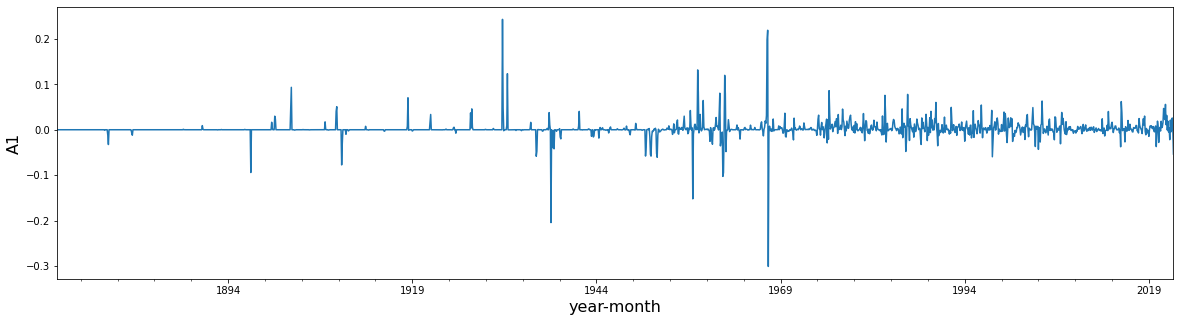

In [29]:
#plot the A1(t) vs time
df_month_sum['A1'].plot(figsize=(20,5))
plt.xlabel('year-month', fontsize=16)
plt.ylabel('A1', fontsize=16)

<AxesSubplot:xlabel='index', ylabel='A2'>

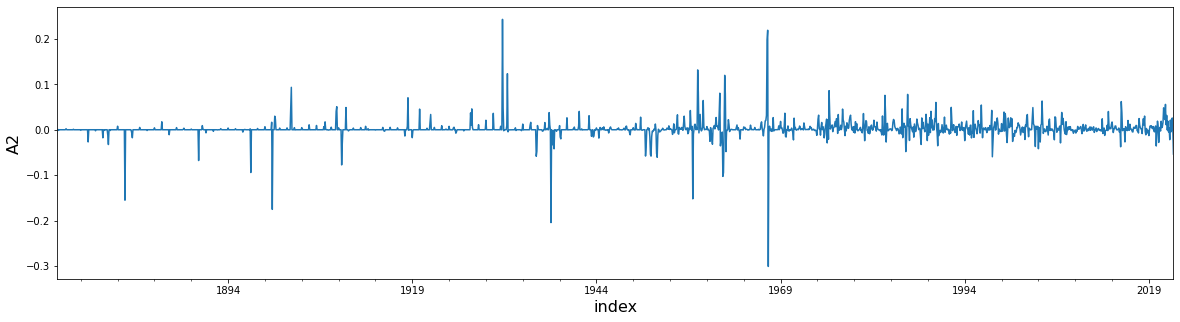

In [30]:
#plot the A2(t) vs time
plt.xlabel('year-month', fontsize=16)
plt.ylabel('A2', fontsize=16)
df_month_sum['A2'].plot(figsize=(20,5))


In [31]:
from statsmodels.tsa.seasonal import STL

Text(0, 0.5, 'A(t)')

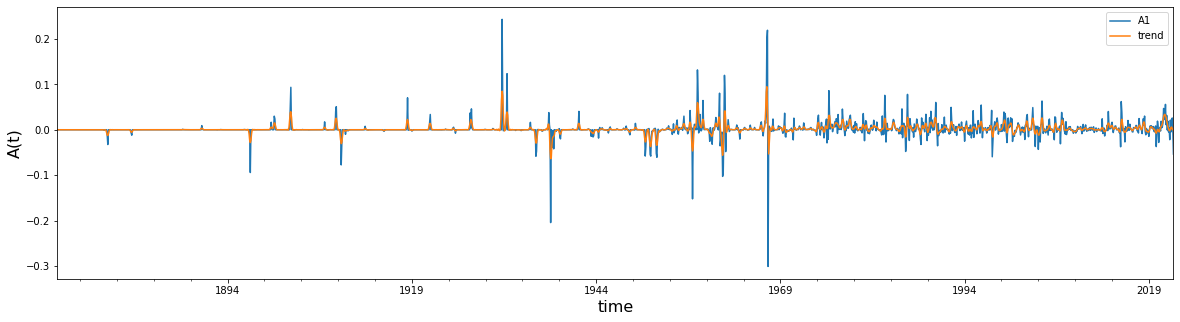

In [32]:
# seasonal decomposition
# choose method A1 to simulate new constructions
# choose period =3 and not robust to outlier
stl = STL(df_month_sum['A1'].dropna() , period=3, robust=False)
res = stl.fit()
res.observed.plot(figsize=(20,5))
res.trend.plot(figsize=(20,5))
plt.legend()
plt.xlabel('time', fontsize=16)
plt.ylabel('A(t)', fontsize=16)


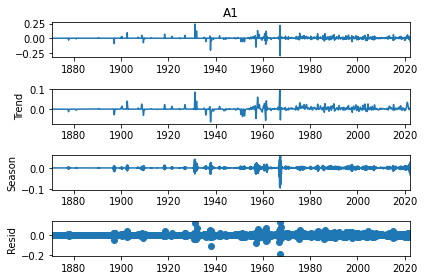

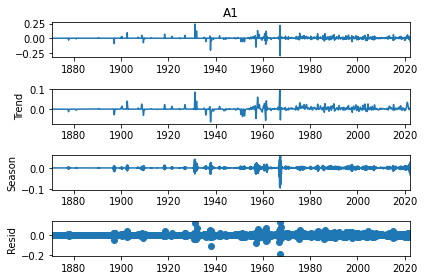

In [33]:
#plot trend, season and resid
res.plot()

In [34]:
# only keep the trend part
df_month_sum['trend'] = res.trend

In [35]:
# construct the housing univers starting from property sale date during 05-2022
# use the mean of the total housing price in 05-2022 as the starting point of I
df_univ = X[X['SALEDATE']>='2022-05-01'].reset_index(drop=True)
I_curr = df_univ.SALEPRICE.mean()
df_month_I = df_month_sum.copy().dropna()

In [36]:
# a recursive function HVI to calculate I(t-1)=I(t)/(1+A(t))
def HVI(t_curr, I_curr, t, A):
    """
    description: a recursive function HVI to calculate I(t-1)=I(t)/(1+A(t))
    input:
        t_curr: current time
        I_curr: I at current time
        t: time
        A: Appreciation list, 
    output:
        (HVI at time t+1)/(1+A[t+1])
    
    """
    if t == t_curr:
        return I_curr / (1 + A[-1])
    return HVI(t_curr, I_curr, t+1, A)/(1+A[t+1])

In [37]:
def generate_I(X):
    """
    description: compute all HVIs
    input:
        X: Appreciation list 
    output:
        HVI list
    """
    A = X.to_list().copy()
    t_curr = len(X)-1
    I = []
    for t in range(t_curr,-1,-1):
        I.append(HVI(t_curr, I_curr, t, A))
    return I[::-1]

In [38]:
# generate HVI for different method A1, A2 and A1 with only trends
df_month_I["I1"]= generate_I(df_month_I['A1'])
df_month_I["I2"] = generate_I(df_month_I['A2'])
df_month_I["I1_trend"]= generate_I(df_month_I['trend'])

# generate moving average of 3, 6, 12, 24 month based on A1 with trends
df_month_I["I1_trend_MA3"] = df_month_I["I1_trend"].rolling(3).mean()
df_month_I["I1_trend_MA6"] = df_month_I["I1_trend"].rolling(6).mean()
df_month_I["I1_trend_MA12"] = df_month_I["I1_trend"].rolling(12).mean()
df_month_I["I1_trend_MA24"] = df_month_I["I1_trend"].rolling(24).mean()

Text(0, 0.5, 'number of properties')

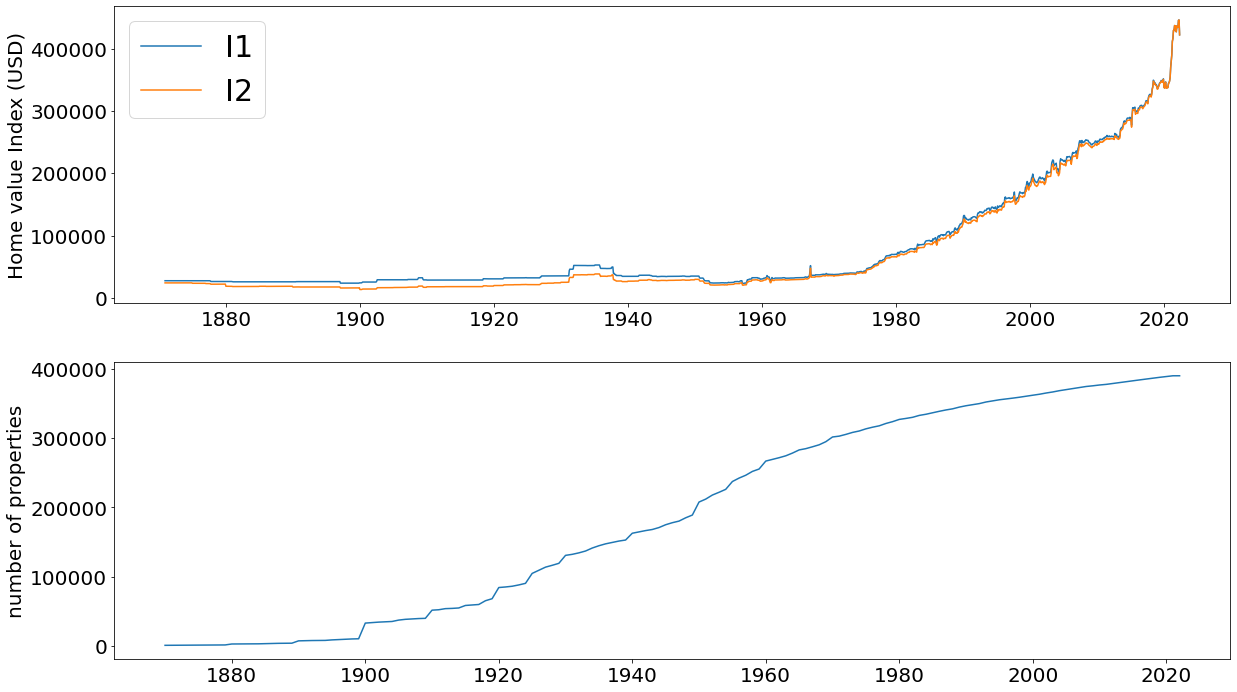

In [39]:
# plot pure I1 or I2 vs time and the number of properties vs time
plt.rcParams.update({'font.size':20})
plt.rcParams['legend.fontsize'] = 30
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(df_month_I.index, df_month_I["I1"].values)
ax1.plot(df_month_I.index, df_month_I["I2"].values)
ax1.legend(["I1","I2"],loc="upper left")
ax1.set_ylabel('Home value Index (USD)', fontsize=20)
ax2.plot(df_n.index, df_n.values)
ax2.set_ylabel('number of properties', fontsize=20)

<AxesSubplot:xlabel='index'>

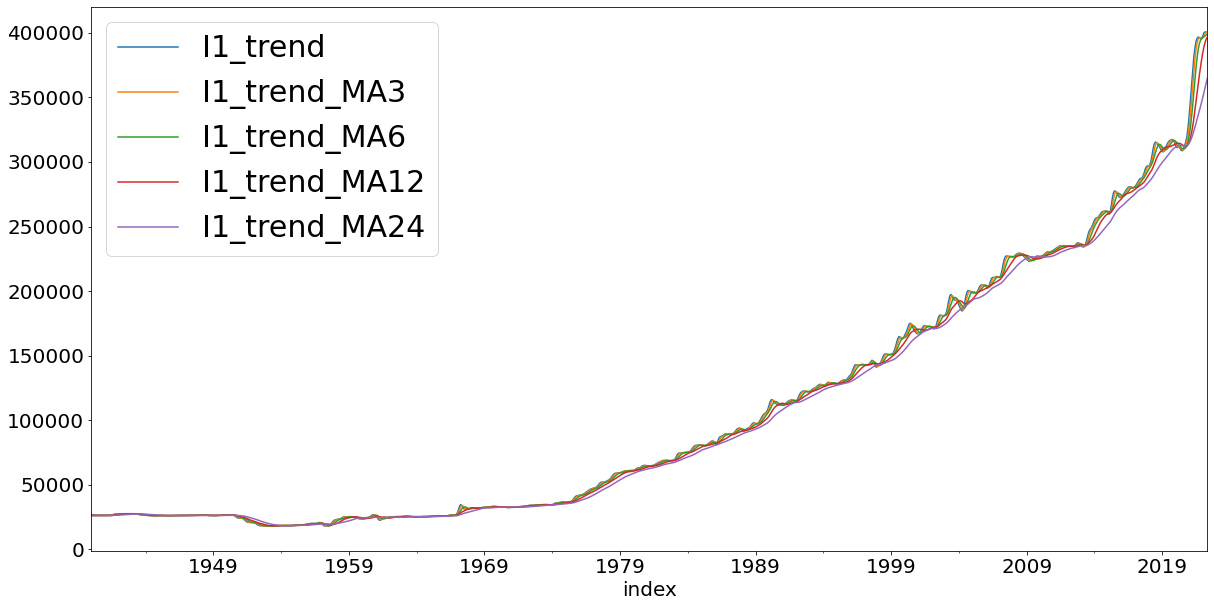

In [40]:
#plot I1 with only trend in different moving average after year 1949 
df_month_I[["I1_trend","I1_trend_MA3","I1_trend_MA6","I1_trend_MA12","I1_trend_MA24"]].loc['1940-01-01':].plot(figsize=(20,10))

Text(0, 0.5, 'Home value Index (USD)')

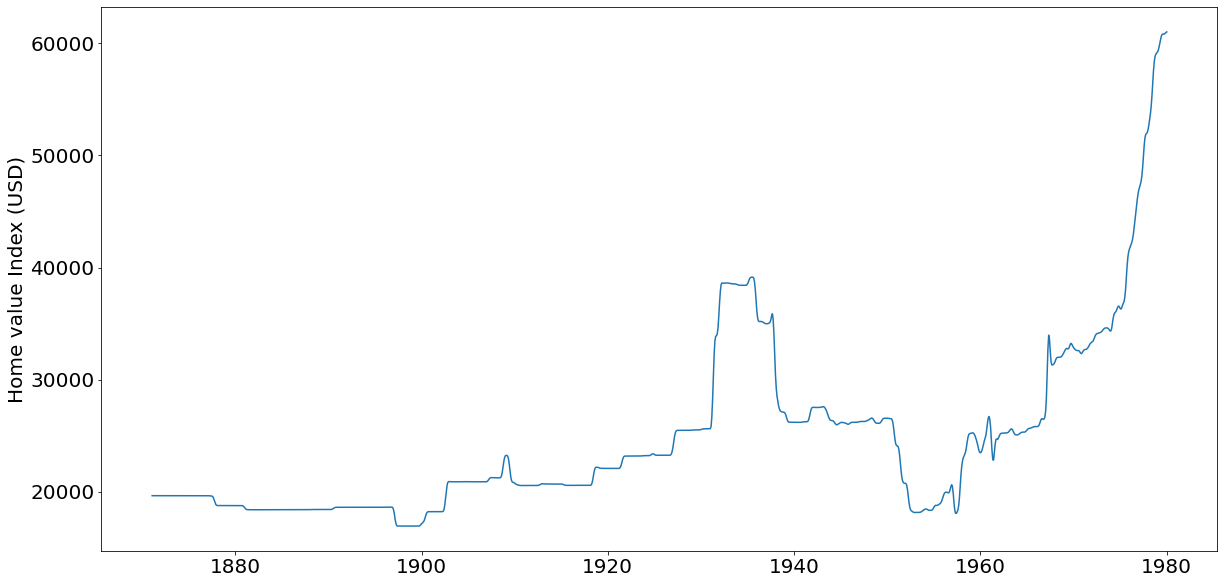

In [46]:
# 24 month moving average in the time range before 1980
plt.figure(figsize=(20,10))
plt.plot(df_month_I.loc[:'1980-01-01'].index, df_month_I["I1_trend_MA3"].loc[:'1980-01-01'].values)
plt.rcParams.update({'font.size':20})
plt.ylabel('Home value Index (USD)', fontsize=20)

Text(0, 0.5, 'Home value Index (USD)')

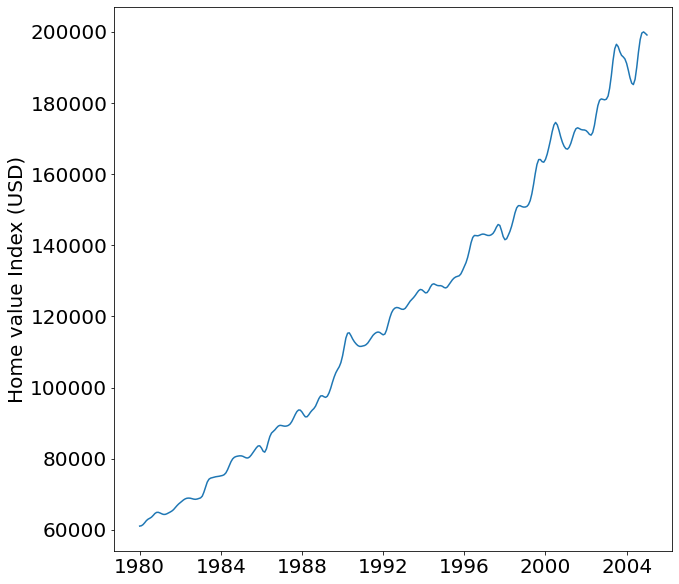

In [42]:
# 3 month moving average in the time range of 1980 to 2005
plt.figure(figsize=(10,10))
plt.plot(df_month_I.loc['1980-01-01':'2005-01-01'].index, df_month_I["I1_trend_MA3"].loc['1980-01-01':'2005-01-01'].values)
plt.rcParams.update({'font.size':20})
plt.ylabel('Home value Index (USD)', fontsize=20)

Text(0, 0.5, 'Home value Index (USD)')

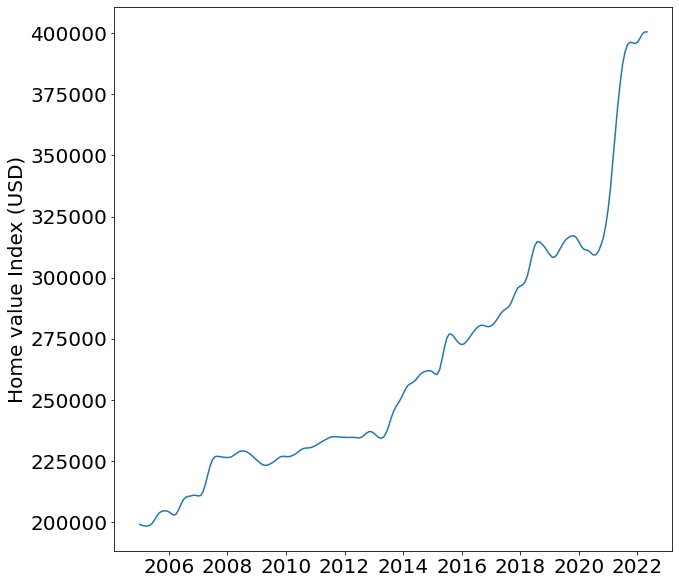

In [43]:
# 3 month moving average in the time range after 2005
plt.figure(figsize=(10,10))
plt.plot(df_month_I.loc['2005-01-01':].index, df_month_I["I1_trend_MA3"].loc['2005-01-01':].values)
plt.rcParams.update({'font.size':20})
plt.ylabel('Home value Index (USD)', fontsize=20)

Text(0, 0.5, 'Home value Index (USD)')

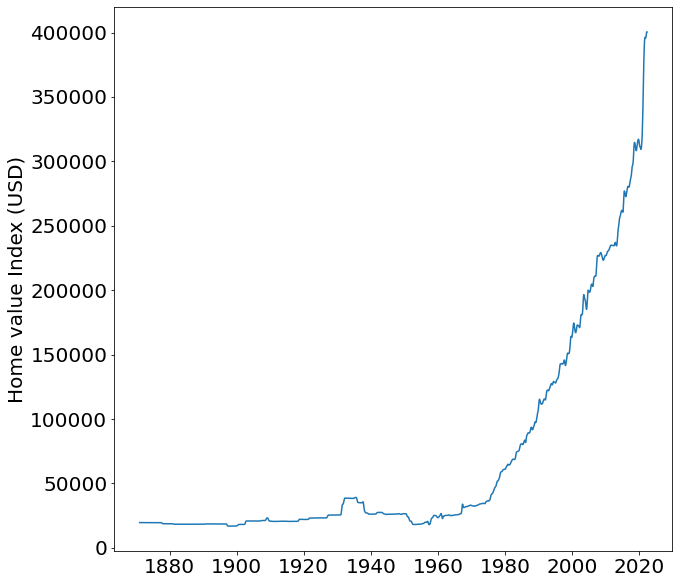

In [45]:
# 3 month moving average 
plt.figure(figsize=(10,10))
plt.plot(df_month_I.index, df_month_I["I1_trend_MA3"].values)
plt.rcParams.update({'font.size':20})
plt.ylabel('Home value Index (USD)', fontsize=20)